In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from train_models import *
from evaluate_models import *

In [2]:
model_names = ['ARMA', 'LSTM', 'GRU']

frequencies = ['D', '60min', '15min', '5min', 'min']
frequencies_number_of_samples = np.multiply([1, 7, 26, 78, 390], 252)

Frequency: D
ARMA
Period: 0, order: [0. 0.], mse: [4.61537205e-04 9.17540686e-05]
Period: 1, order: [0. 0.], mse: [0.00043868 0.00012658]
Period: 2, order: [0. 0.], mse: [1.70967985e-04 6.93918433e-05]
Period: 3, order: [0. 0.], mse: [9.30724410e-05 6.02110774e-05]
Period: 4, order: [0. 0.], mse: [8.54570920e-05 2.47004967e-04]
Period: 5, order: [0. 0.], mse: [1.25429437e-04 6.34113646e-05]
Period: 6, order: [0. 0.], mse: [1.23299848e-04 5.66431895e-05]
Period: 7, order: [0. 0.], mse: [1.22248954e-04 4.48268660e-05]
Period: 8, order: [0. 0.], mse: [5.47238238e-05 2.93307003e-05]
Period: 9, order: [0. 0.], mse: [4.32906717e-05 3.62218798e-05]
Period: 10, order: [0. 0.], mse: [3.65947036e-05 5.76563209e-05]
Period: 11, order: [1. 0.], mse: [4.02721001e-05 3.69382888e-05]
Period: 12, order: [0. 0.], mse: [4.33171505e-05 1.25551967e-04]
Period: 13, order: [0. 0.], mse: [7.28654265e-05 6.76066392e-05]
Period: 14, order: [0. 0.], mse: [7.62030212e-05 2.42941148e-05]
Period: 15, order: [0. 0.

|  1        | -5.534e-0 |  8.592    |  0.1167   |  33.27    |  0.8362   |  11.95    |  20.32    |  2.01     |  1.591    |
|  2        | -5.583e-0 |  6.878    |  0.3987   |  17.0     |  0.7223   |  10.23    |  7.625    |  3.224    |  1.283    |
|  3        | -5.645e-0 |  9.172    |  0.05829  |  1.395    |  0.6711   |  0.2109   |  39.57    |  3.949    |  1.839    |
Period time: 0.45 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -4.398e-0 |  4.677    |  0.3919   |  14.35    |  0.8599   |  1.34     |  5.144    |  2.919    |  1.302    |
|  2        | -4.474e-0 |  4.525    |  0.4965   |  34.83    |  0.5911   |  6.365    |  31.29    |  3.092    |  0.5635   |
|  3        | -4.515e-0 |  8.582    |  0.152    |  1.09     |  0.7022   |  14.94    |  39.51    |  1.644    | 

|  2        | -2.491e-0 |  6.069    |  0.2886   |  1.284    |  0.7116   |  8.247    |  20.16    |  1.134    |  1.651    |
|  3        | -2.426e-0 |  9.397    |  0.3115   |  39.77    |  0.4943   |  0.6703   |  1.087    |  1.925    |  0.663    |
Period time: 0.4 minutes
LSTM training time: 6.66 minutes
GRU
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.000315 |  7.53     |  0.361    |  21.16    |  0.5142   |  11.55    |  31.7     |  2.387    |  1.357    |
|  2        | -0.000302 |  5.035    |  0.4728   |  19.29    |  0.8042   |  0.3248   |  16.71    |  2.002    |  0.4262   |
|  3        | -0.000307 |  5.024    |  0.1054   |  39.48    |  0.8186   |  14.81    |  1.426    |  2.33     |  0.5131   |
Period time: 0.46 minutes
Period: 1
|   iter    |  target   | batch_... | 

|  3        | -5.667e-0 |  8.659    |  0.4378   |  1.142    |  0.4606   |  0.1241   |  1.006    |  3.572    |  1.837    |
Period time: 0.39 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -4.452e-0 |  7.028    |  0.3115   |  26.34    |  0.8104   |  13.75    |  27.69    |  2.098    |  0.3763   |
|  2        | -4.409e-0 |  5.678    |  0.3055   |  25.07    |  0.8643   |  5.595    |  6.482    |  1.249    |  1.576    |
|  3        | -4.541e-0 |  5.042    |  0.1469   |  1.248    |  0.4975   |  0.6386   |  39.45    |  1.403    |  0.8041   |
Period time: 0.47 minutes
Period: 9
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
--------------------------------------------------------------------------

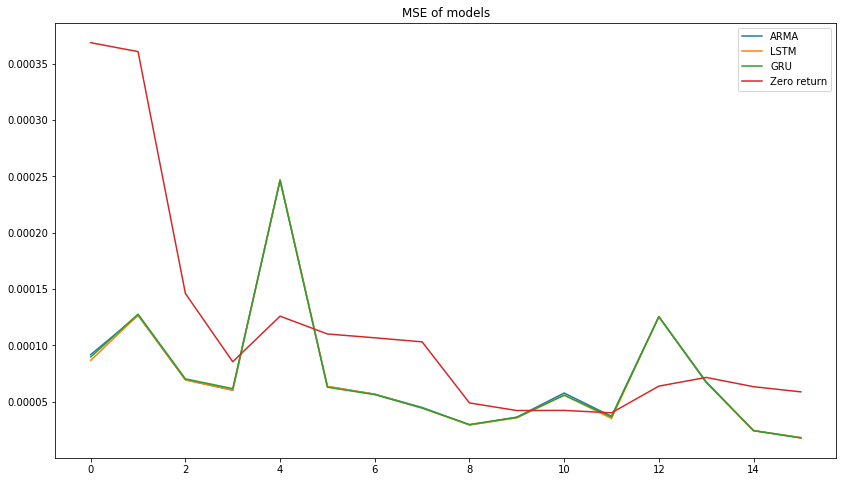

In [3]:
train(0, frequencies, frequencies_number_of_samples)

Frequency: 60min
ARMA
Period: 0, order: [0. 0.], mse: [6.80038215e-05 1.30250384e-05]
Period: 1, order: [0. 0.], mse: [6.50151323e-05 1.88924250e-05]
Period: 2, order: [0. 0.], mse: [2.81016542e-05 1.12872657e-05]
Period: 3, order: [0. 1.], mse: [1.42845695e-05 8.51954257e-06]
Period: 4, order: [0. 1.], mse: [1.28548667e-05 3.52981401e-05]
Period: 5, order: [0. 0.], mse: [1.83674903e-05 8.33010007e-06]
Period: 6, order: [0. 0.], mse: [1.73808292e-05 6.45083703e-06]
Period: 7, order: [1. 0.], mse: [1.66202797e-05 6.11077990e-06]
Period: 8, order: [1. 0.], mse: [6.89431540e-06 4.38040719e-06]
Period: 9, order: [1. 0.], mse: [5.59590527e-06 4.87168230e-06]
Period: 10, order: [0. 0.], mse: [5.12257520e-06 7.34176833e-06]
Period: 11, order: [0. 0.], mse: [5.52277922e-06 5.52512764e-06]
Period: 12, order: [1. 0.], mse: [5.88566391e-06 1.77769376e-05]
Period: 13, order: [0. 1.], mse: [1.01435689e-05 8.82595821e-06]
Period: 14, order: [0. 1.], mse: [1.06229371e-05 4.18143230e-06]
Period: 15, o

|  1        | -6.432e-0 |  6.009    |  0.4956   |  23.04    |  0.678    |  9.776    |  38.18    |  3.214    |  0.8988   |
|  2        | -6.397e-0 |  5.003    |  0.06829  |  12.31    |  0.6995   |  5.336    |  35.81    |  2.337    |  1.952    |
|  3        | -6.418e-0 |  6.723    |  0.1005   |  39.9     |  0.3805   |  0.2951   |  1.011    |  2.257    |  0.1777   |
Period time: 1.49 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -6.129e-0 |  8.604    |  0.4523   |  16.14    |  0.7899   |  2.06     |  33.42    |  2.094    |  0.5826   |
|  2        | -6.136e-0 |  7.188    |  0.4284   |  4.754    |  0.9744   |  9.082    |  30.69    |  3.818    |  1.286    |
|  3        | -6.106e-0 |  9.114    |  0.392    |  39.85    |  0.8301   |  13.68    |  1.022    |  1.399    | 

|  2        | -4.173e-0 |  8.751    |  0.04627  |  17.49    |  0.5272   |  13.56    |  28.24    |  3.934    |  0.6537   |
|  3        | -4.163e-0 |  5.064    |  0.1862   |  39.77    |  0.8438   |  1.315    |  1.111    |  3.253    |  1.773    |
Period time: 0.94 minutes
LSTM training time: 13.14 minutes
GRU
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -5.256e-0 |  4.371    |  0.158    |  7.536    |  0.3796   |  9.267    |  36.49    |  3.85     |  0.5308   |
|  2        | -5.266e-0 |  4.496    |  0.01755  |  9.282    |  0.9064   |  7.424    |  14.87    |  1.509    |  1.66     |
|  3        | -5.255e-0 |  9.301    |  0.1165   |  39.81    |  0.4877   |  1.095    |  1.1      |  2.297    |  0.71     |
Period time: 1.14 minutes
Period: 1
|   iter    |  target   | batch_... 

|  3        | -6.376e-0 |  6.879    |  0.3662   |  39.82    |  0.4899   |  0.1198   |  1.101    |  3.489    |  0.8408   |
Period time: 1.62 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -6.153e-0 |  4.474    |  0.2698   |  1.062    |  0.5337   |  1.79     |  4.873    |  3.165    |  1.96     |
|  2        | -6.093e-0 |  5.707    |  0.2054   |  27.3     |  0.5192   |  6.931    |  24.24    |  3.314    |  1.962    |
|  3        | -6.096e-0 |  6.092    |  0.3431   |  39.84    |  0.8933   |  13.97    |  39.98    |  1.704    |  1.089    |
Period time: 1.19 minutes
Period: 9
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
--------------------------------------------------------------------------

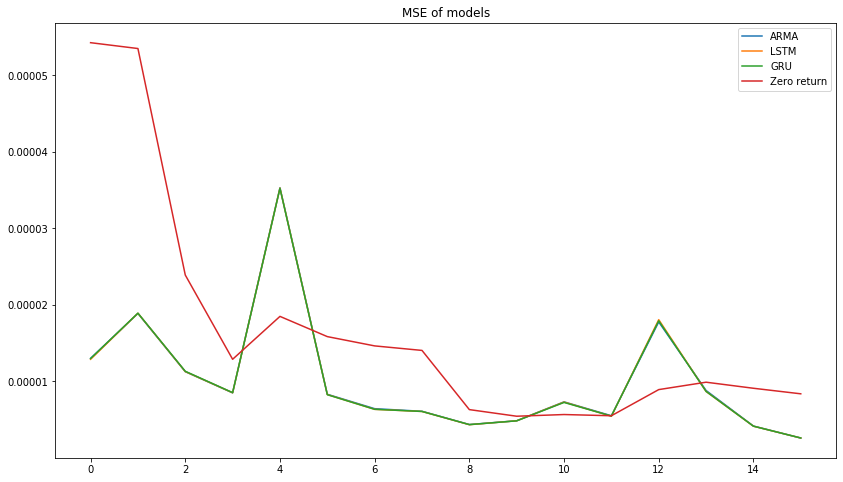

In [4]:
train(1, frequencies, frequencies_number_of_samples)

Frequency: 15min
ARMA
Period: 0, order: [1. 0.], mse: [1.66958132e-05 3.64837977e-06]
Period: 1, order: [1. 0.], mse: [1.59428738e-05 6.58961585e-06]
Period: 2, order: [0. 2.], mse: [8.19202184e-06 2.92180520e-06]
Period: 3, order: [0. 0.], mse: [4.37795123e-06 2.46124189e-06]
Period: 4, order: [0. 1.], mse: [3.98196659e-06 8.72639828e-06]
Period: 5, order: [1. 0.], mse: [4.66378251e-06 2.15814353e-06]
Period: 6, order: [1. 0.], mse: [4.41679240e-06 1.78894295e-06]
Period: 7, order: [1. 0.], mse: [4.19134128e-06 1.64894890e-06]
Period: 8, order: [1. 0.], mse: [1.86458621e-06 1.18127333e-06]
Period: 9, order: [0. 1.], mse: [1.53822711e-06 1.26224262e-06]
Period: 10, order: [0. 1.], mse: [1.35852385e-06 2.06502225e-06]
Period: 11, order: [1. 1.], mse: [1.49487078e-06 1.95456740e-06]
Period: 12, order: [1. 1.], mse: [1.62337843e-06 6.30449416e-06]
Period: 13, order: [1. 0.], mse: [2.79026971e-06 2.26553460e-06]
Period: 14, order: [1. 0.], mse: [2.85848289e-06 1.13213872e-06]
Period: 15, o

|  1        | -1.808e-0 |  5.954    |  0.2071   |  19.28    |  0.8297   |  7.636    |  4.076    |  3.193    |  0.8809   |
|  2        | -1.807e-0 |  8.808    |  0.2105   |  39.04    |  0.7671   |  10.72    |  26.86    |  3.534    |  0.5501   |
|  3        | -1.8e-06  |  5.298    |  0.4353   |  1.463    |  0.3268   |  0.2756   |  39.86    |  1.598    |  0.3429   |
Period time: 3.67 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.648e-0 |  4.411    |  0.08836  |  3.124    |  0.8587   |  14.94    |  16.64    |  2.716    |  1.017    |
|  2        | -1.64e-06 |  8.738    |  0.05814  |  16.23    |  0.6645   |  12.27    |  6.152    |  1.948    |  0.3629   |
|  3        | -1.65e-06 |  5.566    |  0.04326  |  39.91    |  0.4348   |  0.271    |  39.86    |  3.289    | 

|  2        | -1.129e-0 |  4.272    |  0.09583  |  19.06    |  0.4983   |  13.32    |  33.56    |  1.239    |  0.4901   |
|  3        | -1.133e-0 |  9.103    |  0.1726   |  1.441    |  0.3603   |  0.4588   |  1.173    |  3.409    |  0.7141   |
Period time: 2.02 minutes
LSTM training time: 35.11 minutes
GRU
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.446e-0 |  8.458    |  0.1332   |  21.28    |  0.8439   |  14.43    |  19.67    |  1.57     |  0.6804   |
|  2        | -1.448e-0 |  5.626    |  0.3248   |  35.59    |  0.5788   |  7.298    |  29.56    |  3.366    |  0.1319   |
|  3        | -1.437e-0 |  4.829    |  0.3178   |  1.603    |  0.9975   |  0.3471   |  1.557    |  1.195    |  0.107    |
Period time: 1.75 minutes
Period: 1
|   iter    |  target   | batch_... 

|  3        | -1.798e-0 |  6.847    |  0.06487  |  1.221    |  0.5474   |  0.4053   |  39.63    |  1.164    |  1.959    |
Period time: 2.65 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.633e-0 |  8.02     |  0.01375  |  12.81    |  0.7981   |  7.8      |  10.46    |  1.161    |  1.433    |
|  2        | -1.634e-0 |  9.404    |  0.2065   |  36.99    |  0.8466   |  9.528    |  14.54    |  3.364    |  1.826    |
|  3        | -1.651e-0 |  4.484    |  0.3713   |  1.191    |  0.5827   |  2.262    |  39.8     |  3.383    |  0.9606   |
Period time: 1.75 minutes
Period: 9
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
--------------------------------------------------------------------------

GRU training time: 34.76 minutes


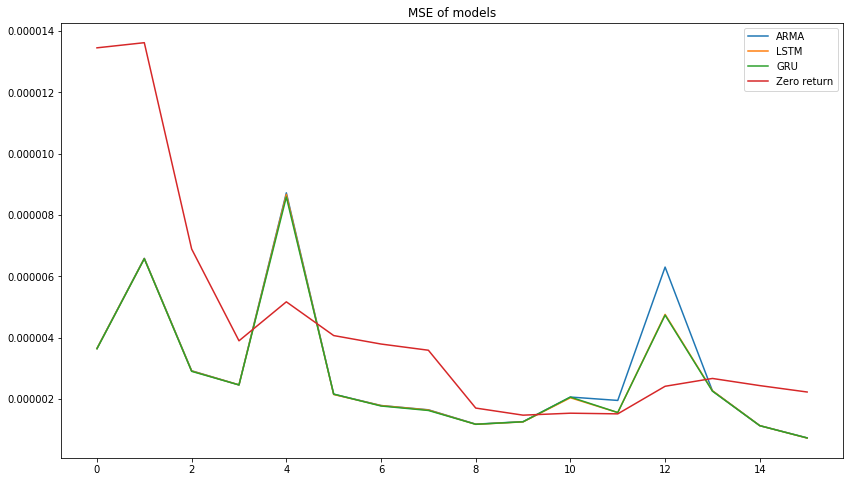

In [5]:
train(2, frequencies, frequencies_number_of_samples)

Frequency: 5min
ARMA
Period: 0, order: [0. 1.], mse: [5.75151378e-06 1.19182384e-06]
Period: 1, order: [0. 1.], mse: [5.47369269e-06 2.01192802e-06]
Period: 2, order: [0. 1.], mse: [2.67318721e-06 9.52145703e-07]
Period: 3, order: [1. 1.], mse: [1.37586087e-06 1.02462929e-06]
Period: 4, order: [1. 1.], mse: [1.25546886e-06 4.10287979e-06]
Period: 5, order: [1. 1.], mse: [1.59940542e-06 8.11880052e-07]
Period: 6, order: [1. 1.], mse: [1.52368618e-06 8.67634121e-07]
Period: 7, order: [0. 1.], mse: [1.43933996e-06 5.48106770e-07]
Period: 8, order: [0. 1.], mse: [6.12281531e-07 3.98802684e-07]
Period: 9, order: [0. 2.], mse: [5.04488571e-07 4.24158182e-07]
Period: 10, order: [0. 2.], mse: [4.53491761e-07 6.91306676e-07]
Period: 11, order: [0. 1.], mse: [5.01694122e-07 4.87494044e-07]
Period: 12, order: [0. 1.], mse: [5.30168419e-07 1.65241307e-06]
Period: 13, order: [1. 1.], mse: [9.30435144e-07 1.19015644e-06]
Period: 14, order: [1. 1.], mse: [9.27957164e-07 3.80449217e-07]
Period: 15, or

|  1        | -5.725e-0 |  9.634    |  0.05334  |  37.91    |  0.4582   |  11.71    |  3.928    |  1.427    |  0.8364   |
|  2        | -5.646e-0 |  9.671    |  0.4077   |  28.92    |  0.8582   |  5.943    |  35.05    |  2.463    |  1.03     |
|  3        | -5.766e-0 |  7.118    |  0.1328   |  1.045    |  0.3855   |  0.09161  |  39.47    |  3.276    |  1.169    |
Period time: 8.72 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -5.483e-0 |  5.833    |  0.265    |  32.51    |  0.5568   |  7.259    |  33.81    |  2.468    |  0.9119   |
|  2        | -5.408e-0 |  4.474    |  0.1254   |  17.12    |  0.3115   |  2.782    |  13.98    |  1.628    |  1.579    |
|  3        | -5.461e-0 |  7.721    |  0.2788   |  1.233    |  0.9042   |  14.76    |  1.413    |  1.53     | 

|  2        | -3.647e-0 |  6.201    |  0.1113   |  31.15    |  0.8545   |  10.38    |  3.559    |  2.687    |  0.8532   |
|  3        | -3.639e-0 |  8.573    |  0.3304   |  1.222    |  0.9911   |  0.4839   |  1.14     |  1.881    |  1.894    |
Period time: 10.3 minutes
LSTM training time: 169.01 minutes
GRU
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -4.834e-0 |  4.263    |  0.4606   |  39.64    |  0.9357   |  9.178    |  4.628    |  3.01     |  1.095    |
|  2        | -4.833e-0 |  8.841    |  0.2624   |  19.48    |  0.4069   |  13.65    |  14.26    |  1.878    |  0.7722   |
|  3        | -4.838e-0 |  7.728    |  0.4833   |  1.233    |  0.562    |  0.3548   |  39.54    |  2.683    |  0.3409   |
Period time: 9.36 minutes
Period: 1
|   iter    |  target   | batch_...

|  3        | -5.823e-0 |  9.847    |  0.3798   |  1.702    |  0.9378   |  0.5957   |  39.83    |  3.332    |  1.966    |
Period time: 5.97 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -5.434e-0 |  4.617    |  0.2116   |  21.95    |  0.8834   |  2.515    |  18.8     |  1.96     |  0.9862   |
|  2        | -5.397e-0 |  9.684    |  0.04449  |  22.83    |  0.67     |  1.095    |  31.88    |  1.977    |  1.514    |
|  3        | -5.46e-07 |  5.471    |  0.4915   |  1.539    |  0.4628   |  14.98    |  1.114    |  1.476    |  0.7169   |
Period time: 5.28 minutes
Period: 9
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
--------------------------------------------------------------------------

GRU training time: 213.8 minutes


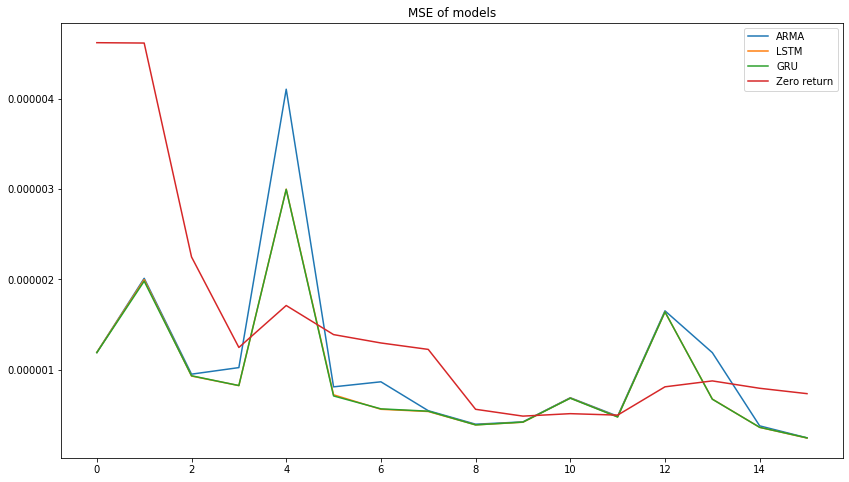

In [6]:
train(3, frequencies, frequencies_number_of_samples)

Frequency: min
ARMA
Period: 0, order: [2. 0.], mse: [1.03904353e-06 2.28883946e-07]
Period: 1, order: [2. 0.], mse: [9.84403427e-07 3.34280763e-07]
Period: 2, order: [2. 0.], mse: [4.80926927e-07 1.70483453e-07]
Period: 3, order: [2. 0.], mse: [2.44323871e-07 1.53201881e-07]
Period: 4, order: [2. 0.], mse: [2.1901714e-07 5.6008426e-07]
Period: 5, order: [2. 0.], mse: [2.94485860e-07 1.34428705e-07]
Period: 6, order: [2. 0.], mse: [2.82538584e-07 1.04457048e-07]
Period: 7, order: [2. 0.], mse: [2.66293966e-07 9.80385107e-08]
Period: 8, order: [1. 1.], mse: [1.12297189e-07 7.03652800e-08]
Period: 9, order: [2. 0.], mse: [9.08082811e-08 7.33336399e-08]
Period: 10, order: [2. 0.], mse: [8.04348281e-08 1.23473187e-07]
Period: 11, order: [2. 0.], mse: [8.89137414e-08 8.55498607e-08]
Period: 12, order: [2. 0.], mse: [9.41022563e-08 3.02611821e-07]
Period: 13, order: [2. 0.], mse: [1.70508335e-07 1.19563243e-07]
Period: 14, order: [3. 0.], mse: [1.69177234e-07 6.67530050e-08]
Period: 15, order

|  1        | -1.039e-0 |  5.663    |  0.4581   |  31.73    |  0.8289   |  2.017    |  14.09    |  2.07     |  1.861    |
|  2        | -1.04e-07 |  9.269    |  0.02504  |  19.52    |  0.7724   |  8.01     |  3.532    |  1.932    |  0.7213   |
|  3        | -1.05e-07 |  6.595    |  0.02169  |  1.031    |  0.7571   |  14.11    |  39.93    |  1.263    |  0.6597   |
Period time: 36.53 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -9.957e-0 |  4.292    |  0.3099   |  31.02    |  0.5648   |  2.375    |  17.32    |  3.795    |  0.8747   |
|  2        | -9.83e-08 |  8.257    |  0.1819   |  16.25    |  0.399    |  7.249    |  16.71    |  2.783    |  0.04949  |
|  3        | -9.939e-0 |  7.496    |  0.4781   |  1.089    |  0.3438   |  13.98    |  39.77    |  3.568    |

|  2        | -6.655e-0 |  9.483    |  0.32     |  24.79    |  0.3684   |  14.94    |  18.33    |  2.364    |  1.298    |
|  3        | -6.665e-0 |  6.269    |  0.2471   |  1.011    |  0.8316   |  1.268    |  39.98    |  3.998    |  1.324    |
Period time: 17.79 minutes
LSTM training time: 648.78 minutes
GRU
Period: 0
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -8.754e-0 |  7.107    |  0.1673   |  8.123    |  0.9528   |  8.203    |  12.68    |  2.831    |  1.4      |
|  2        | -8.862e-0 |  4.091    |  0.3592   |  32.77    |  0.6715   |  14.56    |  12.24    |  2.92     |  0.4904   |
|  3        | -8.846e-0 |  7.672    |  0.4448   |  1.111    |  0.3064   |  0.09933  |  39.76    |  2.225    |  1.615    |
Period time: 21.16 minutes
Period: 1
|   iter    |  target   | batch_.

|  3        | -1.041e-0 |  5.038    |  0.03051  |  39.93    |  0.594    |  0.7299   |  1.108    |  1.68     |  1.533    |
Period time: 41.82 minutes
Period: 8
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -9.852e-0 |  5.169    |  0.3836   |  11.94    |  0.7313   |  6.643    |  17.58    |  1.636    |  1.75     |
|  2        | -9.83e-08 |  4.043    |  0.04253  |  39.74    |  0.8569   |  8.362    |  28.55    |  3.586    |  0.5488   |
|  3        | -9.886e-0 |  9.295    |  0.3697   |  1.005    |  0.7073   |  0.2869   |  1.297    |  1.555    |  1.368    |
Period time: 46.71 minutes
Period: 9
|   iter    |  target   | batch_... |  dropout  | first_... | layer_... | learni... | look_back | n_layers  | optimizer |
------------------------------------------------------------------------

GRU training time: 692.3 minutes


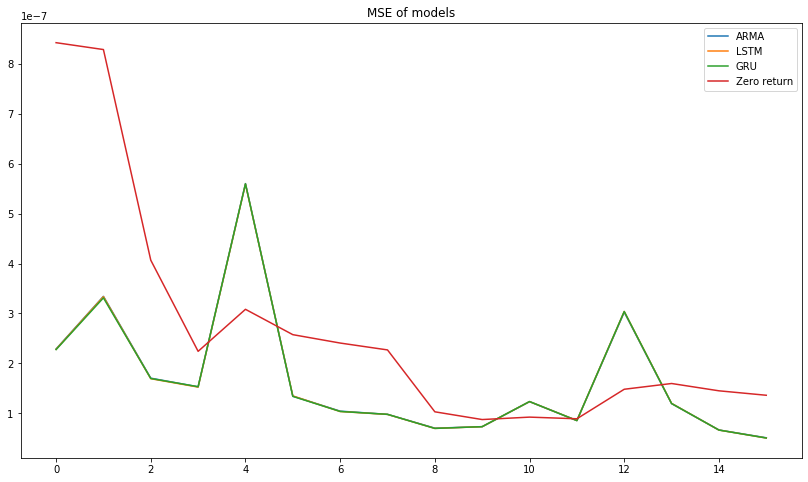

In [7]:
train(4, frequencies, frequencies_number_of_samples)

Frequency: D
Frequency: 60min
Frequency: 15min
Frequency: 5min
Frequency: min


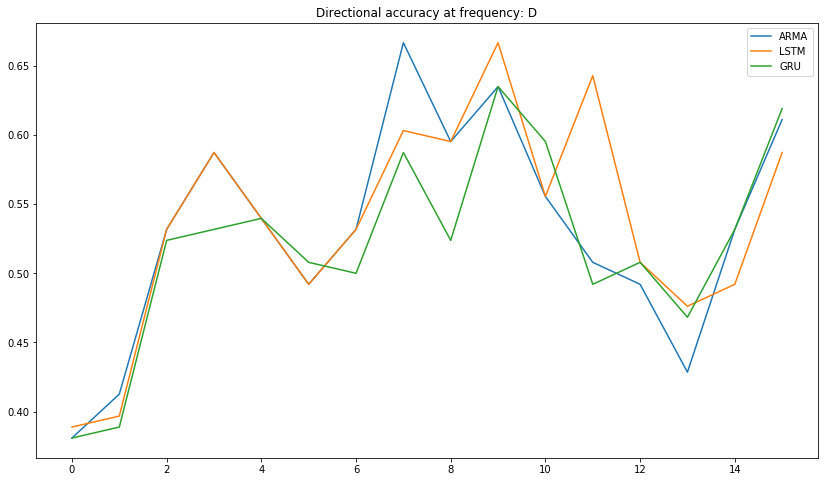

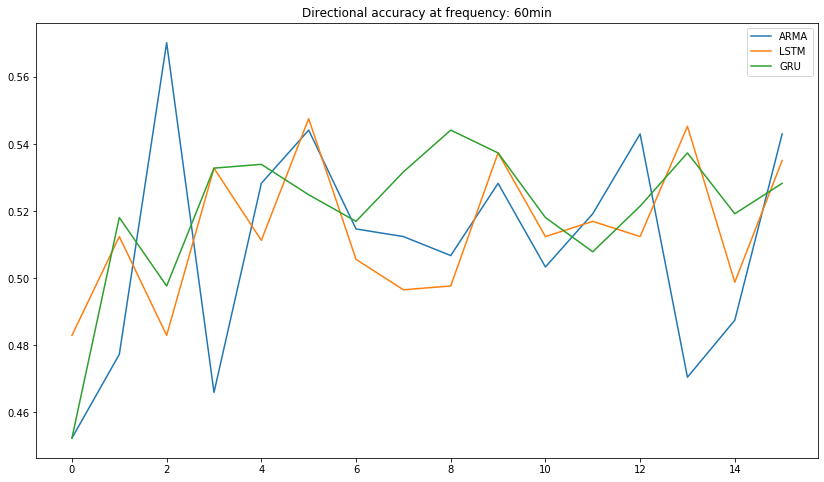

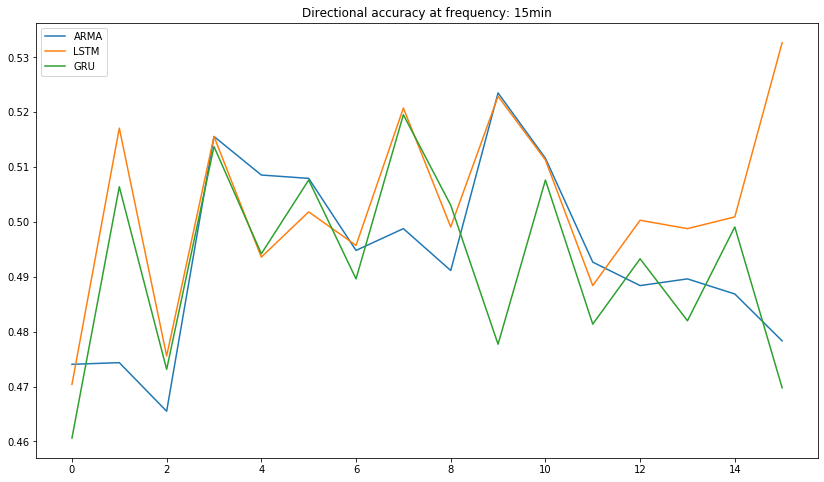

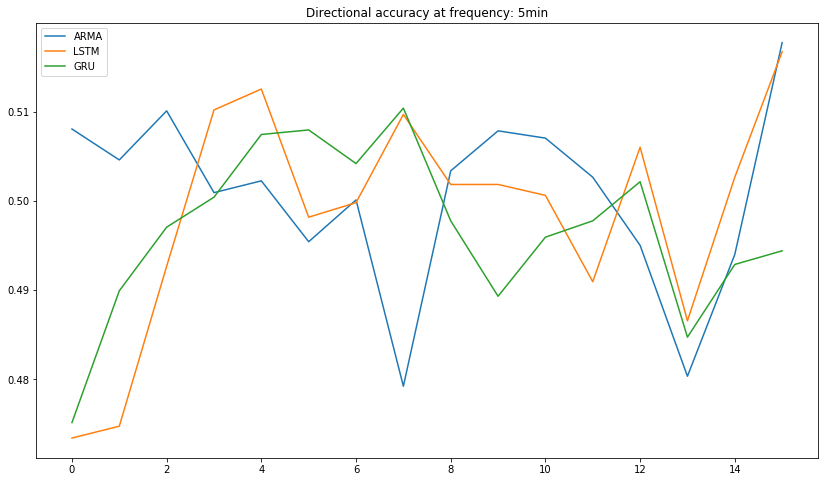

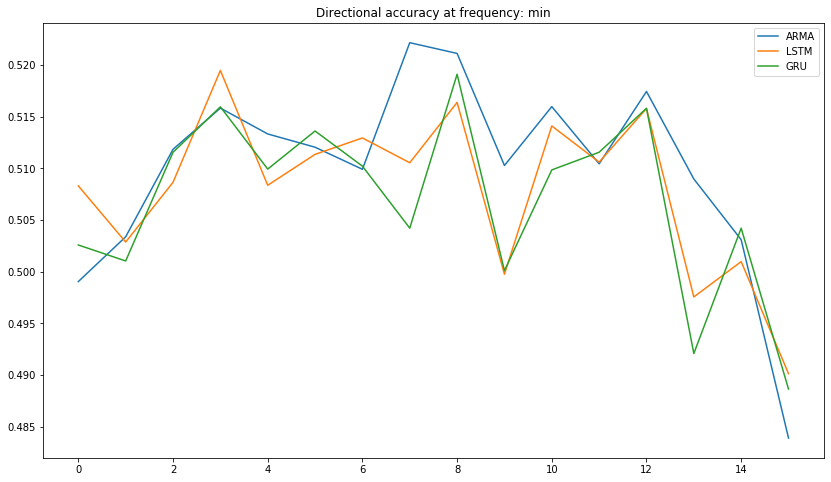

In [8]:
directional_accuracy = calculate_directional_accuracy(model_names, frequencies, frequencies_number_of_samples)
vis_directional_accuracy(directional_accuracy, frequencies, model_names)

Frequency: D
Frequency: 60min
Frequency: 15min
Frequency: 5min
Frequency: min


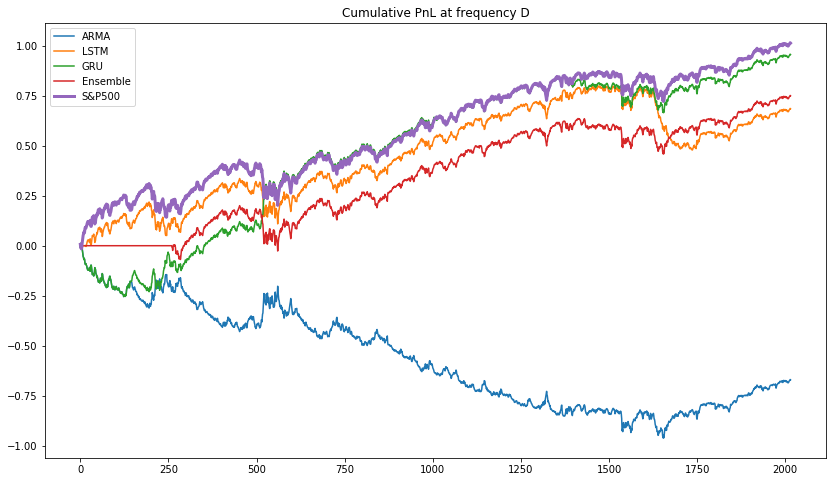

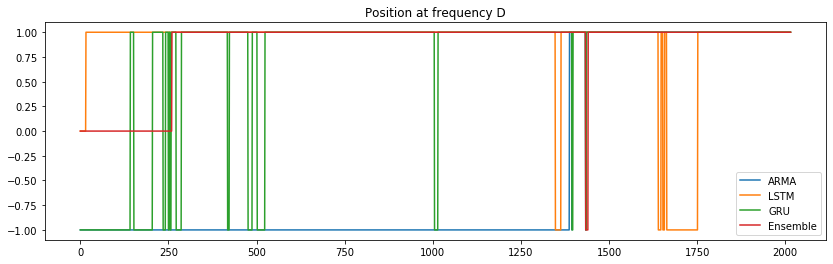

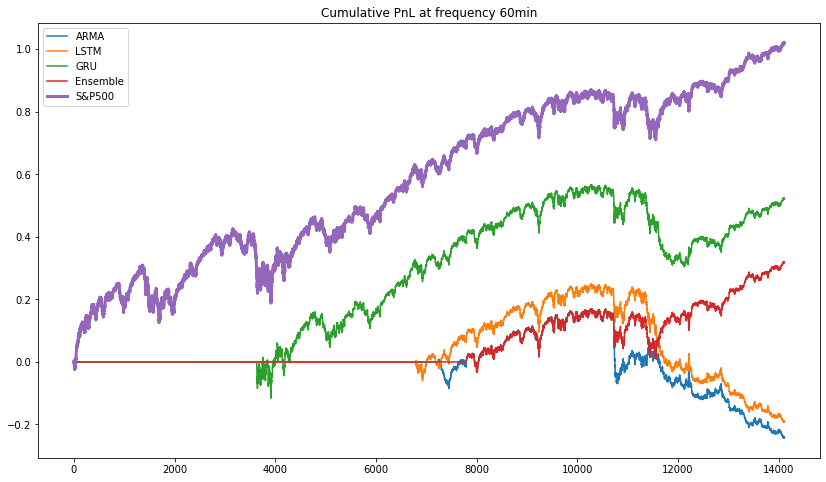

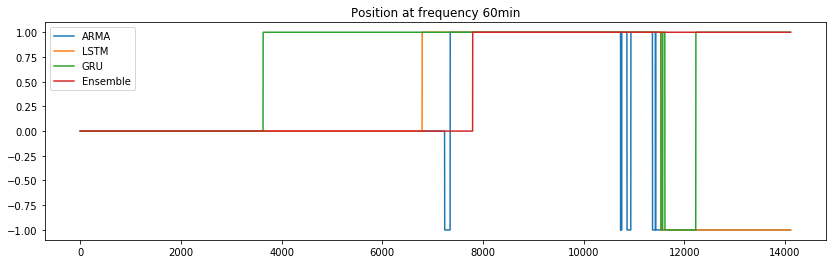

c:\program files\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


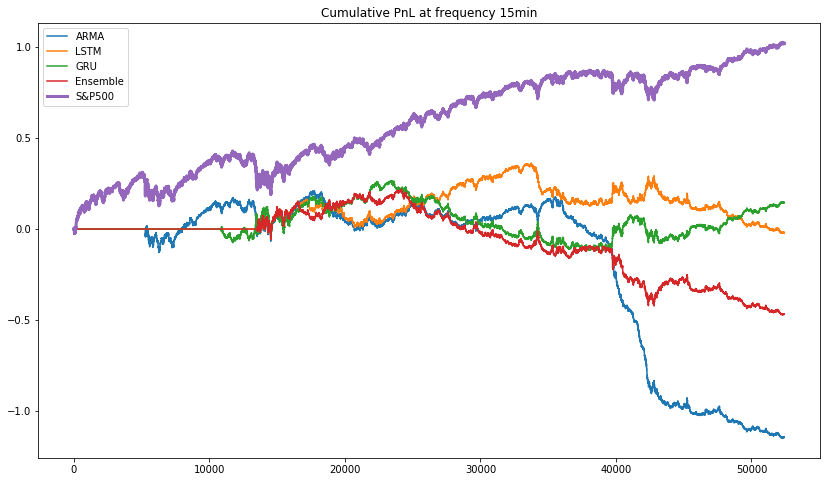

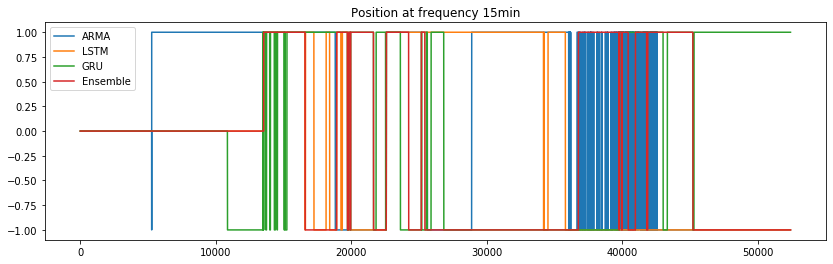

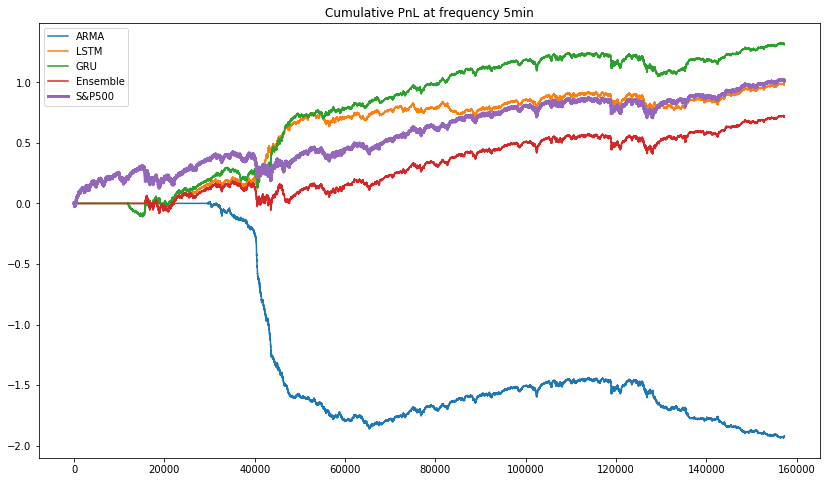

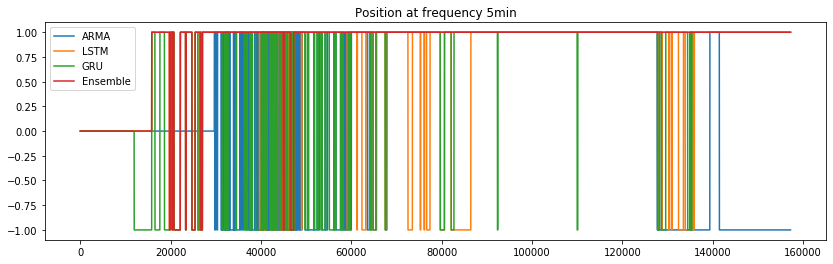

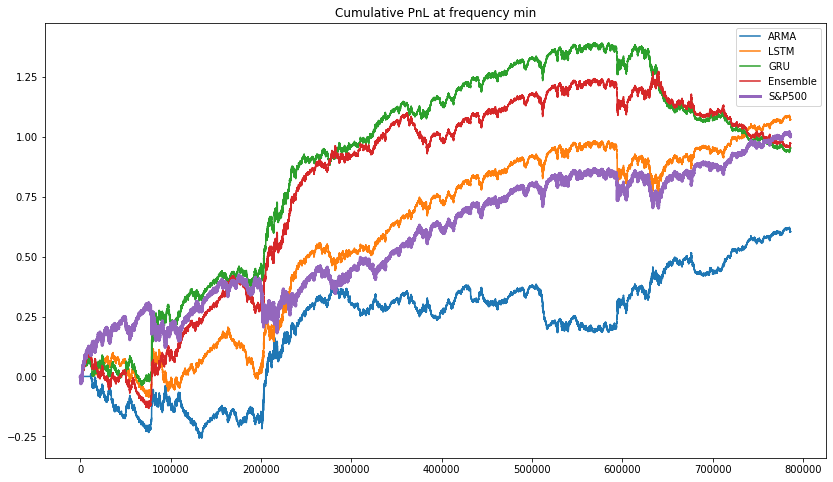

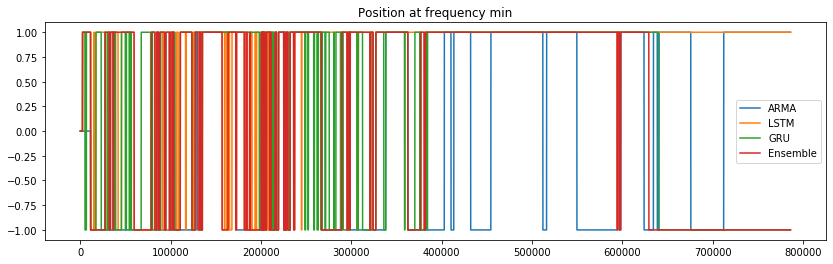

In [3]:
transaction_cost = 0.001
predictions, returns = append_periods(model_names, frequencies, frequencies_number_of_samples)
trading_strategy = calculate_trading_strategy(predictions, transaction_cost)
PnL = create_PnL(trading_strategy, returns, transaction_cost)
vis_cum_PnL(PnL, returns, trading_strategy, frequencies)

In [ ]:
import statsmodels.api as sm
i = 7
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(study_periods[0,i], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(study_periods[0,i], lags=40, ax=ax2)# , lags=40